In [225]:
# para que los cambios en .scr se reflejen en el notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
# para usar los modulos de src
import sys
from pathlib import Path
notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

# carga las variables de entorno
from dotenv import load_dotenv
load_dotenv()

False

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, roc_auc_score
# random forest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.preprocessing import PolynomialFeatures

from src.utils.project_paths import RAW_DATA_DIR
from src.data.utils import categorical_columns, numeric_cat_columns, numeric_columns
from src.data.preprocessing import detect_missing_columns, map_susp_cobranza
from src.utils.plot_styles import PaletaSeaborn

random_state = 42
paleta_seaborn = PaletaSeaborn()

In [228]:
data_file_path = RAW_DATA_DIR / 'CARTERA_PRUEBA_TECNICA.csv'
if data_file_path.exists():
    df_cartera = pd.read_csv(data_file_path)
else:
    print(f'No existe el archivo {data_file_path}')

tratamiento de la informacion en columnas con errores identificadas en el EDA

In [229]:
df_cartera['susp_cobranza']=df_cartera['susp_cobranza'].apply(map_susp_cobranza)

### nulos en el dataframe

In [230]:
df_cartera_nan = df_cartera[df_cartera.isnull().any(axis=1)]
print(f'Cantidad de registros con valores nulos: {df_cartera_nan.shape[0]}')
print(f'Porcentaje de registros con valores nulos: {df_cartera_nan.shape[0]/df_cartera.shape[0]*100:.2f}%')

Cantidad de registros con valores nulos: 1414
Porcentaje de registros con valores nulos: 6.58%


In [231]:
df_nans_report=detect_missing_columns(df_cartera)
columns_with_nans = df_nans_report['columna'].unique()
print(df_nans_report)

                       columna  cantidad  porcentaje
0                       vnc_no      1075        5.00
1                  vencimiento      1075        5.00
2           n_salientes_offnet      1075        5.00
3  dias_hasta_elpago_ultimomes       358        1.67


para esta ocasion y por falta del contexto del negocio para saber como tratar a los datos nulos, se van a eliminar los registros nulos del dataset

In [232]:

df_cartera.dropna(subset=columns_with_nans,inplace=True)
cols_to_use = numeric_cat_columns + numeric_columns

In [233]:
df = df_cartera.copy(deep=True)
df = df[cols_to_use]
df.shape

(20085, 37)

In [234]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [235]:
y.value_counts(normalize=True)

target
1    0.526463
0    0.473537
Name: proportion, dtype: float64

In [236]:
columns_with_nans

array(['vnc_no', 'vencimiento', 'n_salientes_offnet',
       'dias_hasta_elpago_ultimomes'], dtype=object)

### Baseline Regresion Logistica

In [241]:
lr_model = LogisticRegression(random_state=random_state, max_iter=1000, class_weight='balanced')
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('clf', lr_model)
])

# hiperparámetros
param_grid = {
    'poly__degree': [1, 2],  
    'select_k_best__k': [5, 10, 'all'],
    'clf__C': [0.001, 0.01, 0.1],
    'clf__penalty': [ 'l2']
}

scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score)
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_lr = GridSearchCV(    logistic_pipeline, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring=scoring, refit='recall' )

# Ajustar el modelo
print("Iniciando GridSearchCV para Regresión Logística...")
grid_search_lr.fit(X_train, y_train)
print("GridSearchCV completado.")

Iniciando GridSearchCV para Regresión Logística...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


GridSearchCV completado.


In [296]:
print("Mejores parámetros:", grid_search_lr.best_params_)
print("Mejor Recall:", grid_search_lr.best_score_)

best_model_lr = grid_search_lr.best_estimator_


Mejores parámetros: {'clf__C': 0.001, 'clf__penalty': 'l2', 'poly__degree': 2, 'select_k_best__k': 'all'}
Mejor Recall: 0.7535759256893626


Accuracy: 0.76
              precision    recall  f1-score   support

          No       0.74      0.75      0.74      2854
          Si       0.77      0.76      0.77      3172

    accuracy                           0.76      6026
   macro avg       0.76      0.76      0.76      6026
weighted avg       0.76      0.76      0.76      6026



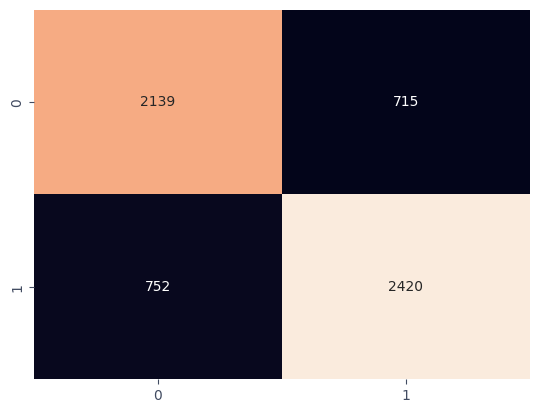

In [346]:
y_pred = best_model_lr.predict(X_test)
acc_lr=roc_auc_score(y_test, y_pred)
print(f'Accuracy: {acc_lr:.2f}')

cr_log_reg = classification_report(y_test, y_pred,output_dict=True)
print(classification_report(y_test, y_pred, target_names=['No', 'Si']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',cbar=False)
plt.show()

el baseline bajo el modelo mas sencillo nos indica que se puede tener un modelo con un minimo de 74% de accuracy con un recall balanceado para ambas clases

# Random Forest

In [264]:
random_forest_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
random_forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('clf', random_forest_model)
])

param_grid = {
    'select_k_best__k': [5, 10],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
grid_search_rf = GridSearchCV(random_forest_pipeline, param_grid, cv=skf, scoring=scoring,  refit='recall', verbose=2,n_jobs=-1)
print("Iniciando GridSearchCV para Random Forest")
grid_search_rf.fit(X_train, y_train)
print("Finalizado GridSearchCV para Random Forest")

Iniciando GridSearchCV para Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Finalizado GridSearchCV para Random Forest


In [274]:
print("\nMejores parámetros:", grid_search_rf.best_params_)
print("Mejor puntaje recall:", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_


Mejores parámetros: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'select_k_best__k': 10}
Mejor puntaje recall: 0.8053190868113218


Accuracy: 0.79
              precision    recall  f1-score   support

          No       0.79      0.76      0.77      2854
          Si       0.79      0.81      0.80      3172

    accuracy                           0.79      6026
   macro avg       0.79      0.79      0.79      6026
weighted avg       0.79      0.79      0.79      6026



<Axes: >

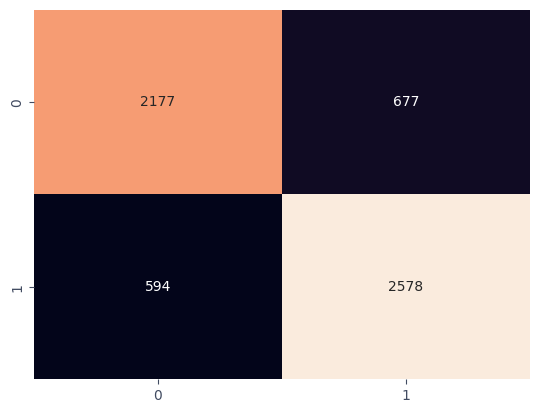

In [347]:
y_pred = best_rf_model.predict(X_test)
acc_rf=roc_auc_score(y_test, y_pred)
print(f'Accuracy: {acc_rf:.2f}')

cr_rf=classification_report(y_test, y_pred,output_dict=True)
print(classification_report(y_test, y_pred, target_names=['No', 'Si']))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d',cbar=False)

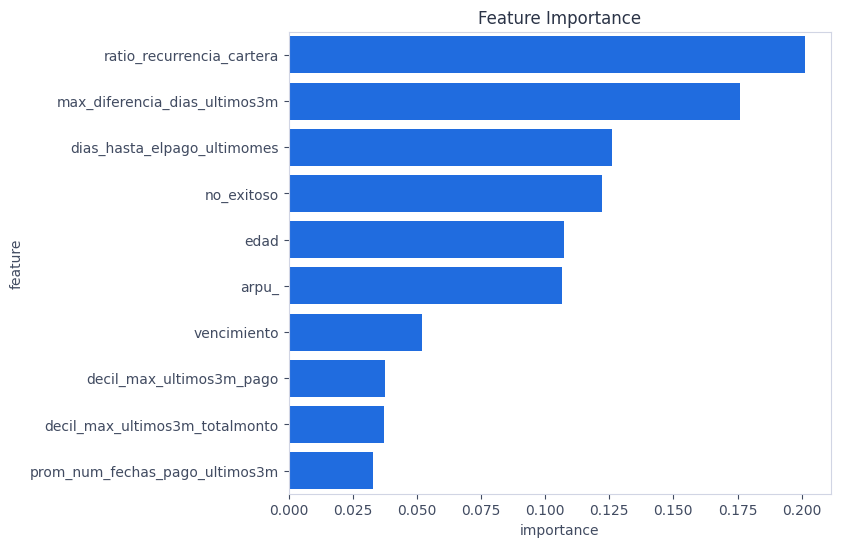

In [355]:
# feature importance
feature_importance = best_rf_model.named_steps['clf'].feature_importances_
features = X_train.columns[best_rf_model.named_steps['select_k_best'].get_support(indices=True)]
df_feature_importance = pd.DataFrame({'feature': features, 'importance': feature_importance})
df_feature_importance = df_feature_importance.sort_values('importance', ascending=False)


plt.figure(figsize=(7, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance,color=paleta_seaborn.color_blue)
plt.title('Feature Importance')
plt.show()

en random forest se obtuvo un modelo capaz de tener un mayor accura

# XGBoosting

In [259]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]

xgb_model = XGBClassifier(random_state=random_state, scale_pos_weight=estimate, eval_metric='logloss',objective="binary:logistic")
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('clf', xgb_model)
])

# hiperparámetros
param_grid = {
    'select_k_best__k': [5, 10, ],
    'clf__n_estimators': [80, 100, 120],
    'clf__max_depth': [5, 7, 12, 15],
    'clf__learning_rate': [0.01, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__min_child_weight': [1, 3, 5]
}

# cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recall_scorer = make_scorer(recall_score, average='binary')
grid_search_xgb = GridSearchCV(xgboost_pipeline, param_grid, cv=skf, n_jobs=-1, verbose=3, scoring=scoring, refit='recall')

print("Iniciando GridSearchCV para XGBoost...")
grid_search_xgb.fit(X_train, y_train)
print("GridSearchCV completado.")



Iniciando GridSearchCV para XGBoost...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
GridSearchCV completado.


In [260]:
# Imprimir los mejores parámetros
print("\nMejores parámetros:", grid_search_xgb.best_params_)
print("Mejor puntaje de Recall:", grid_search_xgb.best_score_)



Mejores parámetros: {'clf__learning_rate': 0.01, 'clf__max_depth': 15, 'clf__min_child_weight': 1, 'clf__n_estimators': 80, 'clf__subsample': 0.6, 'select_k_best__k': 10}
Mejor puntaje de Recall: 0.79140400021899


Accuracy: 78.61%
              precision    recall  f1-score   support

          No       0.78      0.77      0.77      2854
          Si       0.80      0.80      0.80      3172

    accuracy                           0.79      6026
   macro avg       0.79      0.79      0.79      6026
weighted avg       0.79      0.79      0.79      6026



<Axes: >

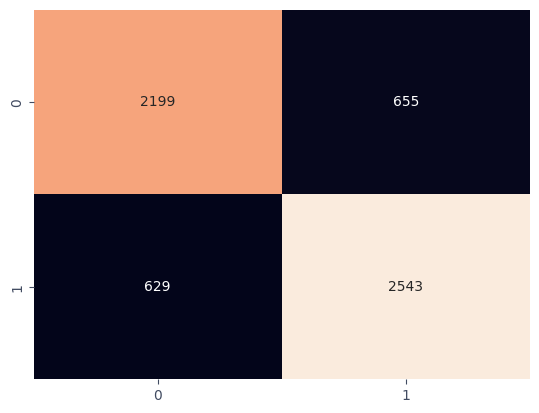

In [348]:
best_xgb_model = grid_search_xgb.best_estimator_
y_pred = best_xgb_model.predict(X_test)

acc_xgb = roc_auc_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (acc_xgb* 100.0))

cr_xgboost = classification_report(y_test, y_pred,output_dict=True)
print(classification_report(y_test, y_pred, target_names=['No', 'Si']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)


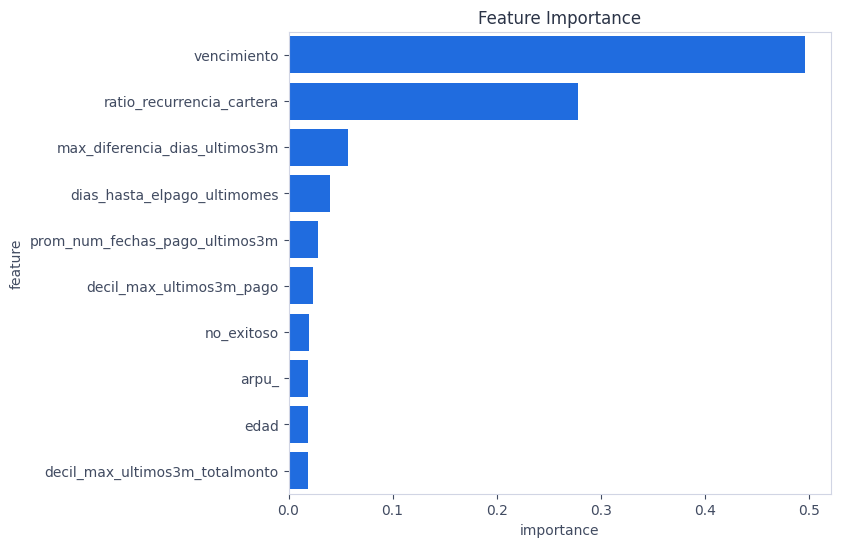

In [354]:
# feature importance
feature_importance = best_xgb_model.named_steps['clf'].feature_importances_
features = X_train.columns[best_xgb_model.named_steps['select_k_best'].get_support(indices=True)]
df_feature_importance = pd.DataFrame({'feature': features, 'importance': feature_importance})
df_feature_importance = df_feature_importance.sort_values('importance', ascending=False)


plt.figure(figsize=(7, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance,color=paleta_seaborn.color_blue)
plt.title('Feature Importance')
plt.show()

## Red Neuronal 

por ultimo se ve una red neuronal con pytorch, para entender como este esta construido revise el script NN_model en el directorio src/models

In [285]:
from src.models.NN_model import CarteraDataLoader, BinaryClassificationModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar,EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from src.utils.project_paths import MODELS_DIR, RESULTS_DIR
import torch

In [329]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [330]:
# Hiperparámetros
NUM_EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE =  0.0001
HIDDEN_DIM =  64
INPUT_DIM = X_train_selected.shape[1]
# Directorios
save_model_dir = MODELS_DIR / 'nn_classifier' 
checkpoint_dir = save_model_dir / "checkpoints"
logs_dir = MODELS_DIR / 'logs'

nn_model = BinaryClassificationModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='nn_classifier-{epoch:02d}-{val_loss:.2f}',
    save_top_k=2,
    monitor='val_accuracy',
    mode='max', every_n_epochs=1
)
# earling sttoping 
early_stop_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode='max'
)

progress_bar = TQDMProgressBar(refresh_rate=1) 
logger = CSVLogger(save_dir=logs_dir, name="nn_classifier")

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[checkpoint_callback, early_stop_callback,progress_bar],
    accelerator="auto",  # Usa GPUs o TPUs si están disponibles
    devices="auto",  # Usa todos los GPUs/TPUs disponibles si es aplicable
    logger=logger,
    deterministic=False,
)

data_module = CarteraDataLoader(X_train_selected, y_train, batch_size=BATCH_SIZE)
trainer.fit(nn_model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\models\nn_classifier\checkpoints exists and is not empty.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | layer1  | Linear  | 704    | train
1 | layer2  | Linear  | 4.2 K  | train
2 | layer3  | Linear  | 65     | train
3 | relu    | ReLU    | 0      | train
4 | dropout | Dropout | 0      | train
--------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\balec\Documents\MisDocumentos\Trabajo\Test_TFN\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


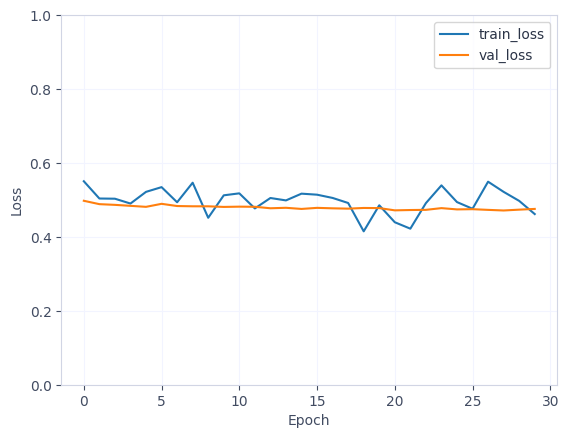

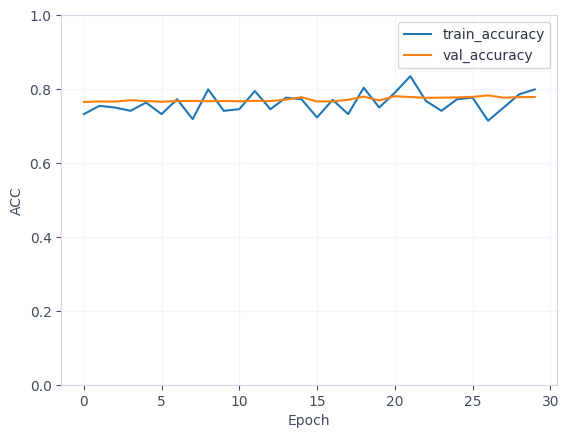

In [331]:
#plot the training and validation loss in df_metrics
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
plt.ylim(0, 1)
plt.savefig(RESULTS_DIR / "nn_loss.png")
df_metrics[["train_accuracy", "val_accuracy"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)
plt.ylim(0, 1)
plt.savefig(RESULTS_DIR / "nn_acc.png")
plt.show()

In [332]:
def predict(model, X):
    model.eval() 
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred = model(X_tensor)
        y_pred_binary = (y_pred > 0.5).float().numpy()
    return y_pred_binary.flatten()

def predict_proba(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred = model(X_tensor)
    return y_pred.numpy().flatten()

Accuracy: 0.79
              precision    recall  f1-score   support

          No       0.77      0.79      0.78      2854
          Si       0.80      0.78      0.79      3172

    accuracy                           0.79      6026
   macro avg       0.79      0.79      0.79      6026
weighted avg       0.79      0.79      0.79      6026



<Axes: >

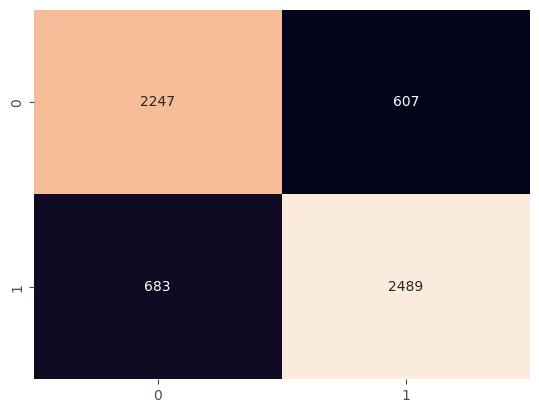

In [349]:
best_model_path = checkpoint_callback.best_model_path
best_nn_model = BinaryClassificationModel.load_from_checkpoint(checkpoint_path=best_model_path,input_dim=X_train_selected.shape[1],hidden_dim=HIDDEN_DIM)
y_pred_nn = predict(best_nn_model, X_test_selected)

acc_nn_model=roc_auc_score(y_test, y_pred_nn)
print(f'Accuracy: {acc_nn_model:.2f}')
cr_nn_model = classification_report(y_test, y_pred_nn,output_dict=True)
print(classification_report(y_test, y_pred_nn, target_names=['No', 'Si']))
conf_matrix = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

## comparacion de resultados

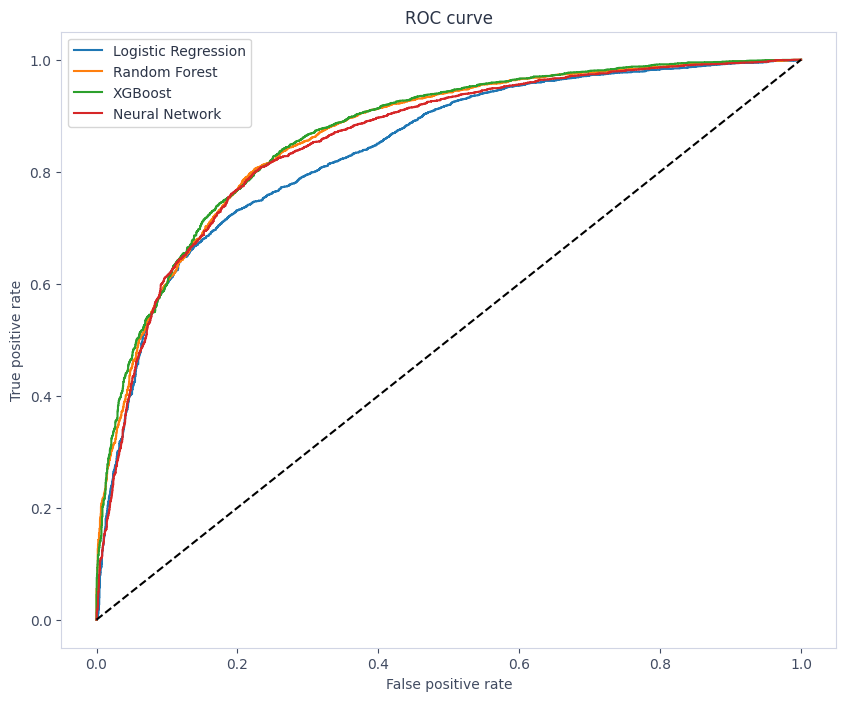

In [338]:
# roc curve for all models in one plot
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, best_model_lr.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:,1])
fpr_nn, tpr_nn, _ = roc_curve(y_test, predict_proba(best_nn_model, X_test_selected))

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

In [353]:
def compare_models(model_dict):
    results = []
    for model_name, res in model_dict.items():
        cr, acc = res
        for class_label in cr.keys():
            if class_label.isdigit(): 
                class_dict = {
                    'modelo': model_name,
                    'clase': class_label,
                    'accuracy': acc,
                    'recall': cr[class_label]['recall'],
                    'precision': cr[class_label]['precision'],
                    'f1': cr[class_label]['f1-score'],
                }
                results.append(class_dict)
    
    return pd.DataFrame(results)


model_dict = {
    'Logistic Regression': [cr_log_reg, acc_lr],
    'Random Forest': [cr_rf, acc_rf],
    'XGBoost': [cr_xgboost, acc_xgb],
    'Neural Network': [cr_nn_model, acc_nn_model]
}

df_model_results = compare_models(model_dict)
df_model_results.to_csv(RESULTS_DIR / 'model_comp_results.csv', index=False)